In [12]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle
import os
%matplotlib inline
np.random.seed(1)

### 1. Load Data Functions

In [13]:
def convert_to_onehot(X, num_classes):
    num_classes = tf.constant(num_classes, name="num_classes")
    one_hot_matrix = tf.one_hot(X, depth= num_classes, axis= 1)
    session = tf.Session()
    X_one_hot = session.run(one_hot_matrix)
    session.close()
    return X_one_hot

In [14]:
def load_data():
    num_classes = 40
    rootDir = '/Users/dibu/Gatech Academics/BigDataSystems-CS6220/Assignments/A1/workspace/Face_dataset/orl_faces'
    X=[]
    y=[]
    label = 0
    flag = 0
    basedir = ""
    for dirName, subdirList, fileList in os.walk(rootDir):
        if flag ==0:
            basedir = dirName
            flag =1
        else:
            for fname in fileList:
                img = Image.open( dirName+'/'+fname )
                data = np.array( img, dtype='uint8' )
                X.append(data)
                y.append(label)
            label = label +1
            
    #Shuffle Data
    arr = np.random.permutation(400)
    X=np.array(X)
    y=np.array(y)
    X = np.take(X,arr,axis=0)
    y = np.take(y,arr,axis=0)
    
    #split Data in train and test
    X_test = X[0:80]
    y_test = y[0:80]
    X_train = X[80:400]
    y_train = y[80:400]
#     print(y_test)
    y_train = convert_to_onehot(y_train, num_classes)
    y_test = convert_to_onehot(y_test, num_classes)
    return X_test,y_test, X_train,y_train
    

In [15]:
X_test,y_test,X_train,y_train = load_data()
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]


### 2. Dimension Check

In [17]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)
# plt.imshow(X[img])

# print(y_test[0])

(80, 112, 92, 1)
(320, 112, 92, 1)
(80, 40)
(320, 40)


### 3 -  Tensorflow Forward Pass


In [18]:
def create_placeholders(n_H0, n_W0,n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    return X, Y

### 4 - Initialize Filters


In [19]:
def initialize_parameters():
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [4,4,1,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

### 5- Forward Propagation


In [27]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    #Conv2d
#     print(X.shape)
#     print(W1.shape)
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
#     print(Z1.shape)
    # RELU
    A1 = tf.nn.relu(Z1)
#     print(A1.shape)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
#     print(P1.shape)
    # CONV2D
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
#     print(Z2.shape)
    # RELU
    A2 = tf.nn.relu(Z2)
#     print(A2.shape)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides= [1,4,4,1], padding='SAME')
    # FLATTEN
#     print(P2.shape)
    P2 = tf.contrib.layers.flatten(P2)
#     print(P2.shape)
    # FULLY-CONNECTED 
    Z3 = tf.contrib.layers.fully_connected(P2, 40, activation_fn=None)
#     print(Z3.shape)

    return Z3

### 6 - Compute Cost

In [28]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

### 7 - Build Model

In [29]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation]
    shuffled_Y = Y[permutation]
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [30]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 200, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0,n_C0) = X_train.shape    
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

### 8 - Compute Run time and Accuracy

In [31]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    _, _, parameters = f(*args)
    toc = time.time()
    return toc - tic

Cost after epoch 0: 277.620377
Cost after epoch 5: 66.150833
Cost after epoch 10: 37.812290
Cost after epoch 15: 22.174259
Cost after epoch 20: 11.614561
Cost after epoch 25: 6.045000
Cost after epoch 30: 2.860270
Cost after epoch 35: 1.315531
Cost after epoch 40: 0.594865
Cost after epoch 45: 0.252364
Cost after epoch 50: 0.088011
Cost after epoch 55: 0.049322
Cost after epoch 60: 0.028458
Cost after epoch 65: 0.019089
Cost after epoch 70: 0.015157
Cost after epoch 75: 0.012741
Cost after epoch 80: 0.011084
Cost after epoch 85: 0.009828
Cost after epoch 90: 0.008771
Cost after epoch 95: 0.007694


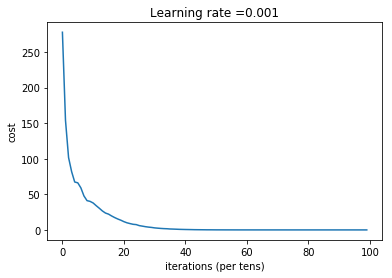

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.6625


In [32]:
execution_time = time_function(model, X_train, y_train, X_test, y_test)

In [33]:
print("Execution Time: " + str(execution_time) + " sec")

Execution Time: 108.71142911911011 sec
